DL apprach see

https://www.analyticsvidhya.com/blog/2019/01/introduction-time-series-classification/

https://towardsdatascience.com/how-to-use-convolutional-neural-networks-for-time-series-classification-56b1b0a07a57
    
or with big guns use attention:
    
https://towardsdatascience.com/attention-for-time-series-classification-and-forecasting-261723e0006d

Data:

https://timeseriesclassification.com/

Misc:

https://tsfresh.readthedocs.io/en/latest/text/quick_start.html

https://github.com/hfawaz/bigdata18

https://paperswithcode.com/paper/an-empirical-evaluation-of-generic

https://paperswithcode.com/paper/multilevel-wavelet-decomposition-network-for

Human activity recognition:

https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

CNN, QRNN

https://stats.stackexchange.com/questions/403502/is-it-a-good-idea-to-use-cnn-to-classify-1d-signal

Temporal convolutions

https://arxiv.org/pdf/1803.01271.pdf

kaggle freesound

https://github.com/sainathadapa/kaggle-freesound-audio-tagging

In [68]:
%matplotlib inline
import pandas as pd
from pandas.plotting import scatter_matrix
from pandas import set_option
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.colors as colors
from sklearn import preprocessing
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from classification_utilities import display_cm, display_adj_cm
from scipy import signal
from skimage import util
import librosa
import librosa.display

We load the training data to start the exploration stage.

In [3]:
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = 'data/CAX_LogFacies_Train_File.csv'
training_data = pd.read_csv(filename)
training_data

,row_id,well_id,GR,label
0,0,0,143.510000,0
1,1,0,112.790928,0
2,2,0,123.531856,0
3,3,0,111.692784,0
4,4,0,123.613712,0
...,...,...,...,...
4399995,1095,3999,161.799008,0
4399996,1096,3999,142.631756,0
4399997,1097,3999,142.734504,0
4399998,1098,3999,140.037252,0


In [4]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4400000 entries, 0 to 4399999
Data columns (total 4 columns):
row_id     int64
well_id    int64
GR         float64
label      int64
dtypes: float64(1), int64(3)
memory usage: 134.3 MB


In [5]:
training_data.label.unique()

array([0, 2, 1, 3, 4])

Observation: very few facies to predict

In [6]:
training_data.GR.min()

-3.1819153274835728

In [7]:
training_data.GR.max()

197.0614194722475

In [8]:
training_data.row_id.max()

1099

In [9]:
training_data.row_id.min()

0

In [10]:
facies_gr=training_data.groupby(['label']).mean()

In [11]:
facies_gr.head()

,row_id,well_id,GR
label,,,
0,567.722586,2002.058160,132.141165
1,528.980774,2001.483643,82.115153
2,525.284301,2005.962593,57.847181
3,528.500096,1994.179747,97.837936
4,534.491175,1984.902727,98.146792


### Preliminary Facies types

<pre>
0: shale
1: silty sst/interbedded
2: sandstone
1: silty sst/interbedded
4: fining up silty sst/interbedded
</pre>

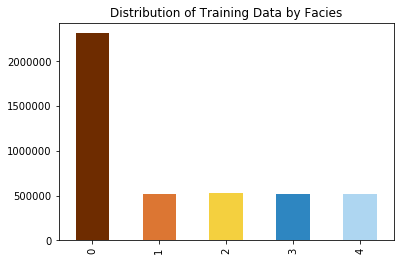

In [12]:
facies_colors = ['#6E2C00','#DC7633','#F4D03F',
                 '#2E86C1', '#AED6F1']

facies_counts = training_data['label'].value_counts().sort_index()
facies_counts.plot(kind='bar',color=facies_colors,title='Distribution of Training Data by Facies')

Very limited data to expect meaningfull correlation accross variables

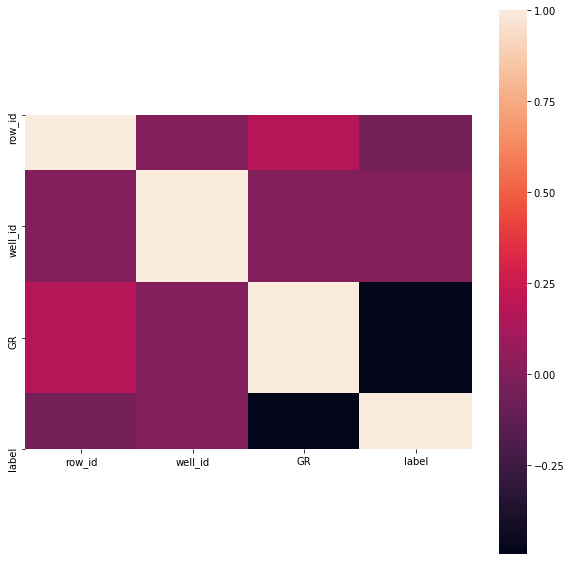

In [13]:
plt.figure(figsize=(10, 10))
sns.heatmap(training_data.corr(), vmax=1.0, square=True)

In [14]:
training_data.describe()

,row_id,well_id,GR,label
count,4.400000e+06,4.400000e+06,4.400000e+06,4.400000e+06
mean,5.495000e+02,1.999500e+03,1.092733e+02,1.184489e+00
std,3.175426e+02,1.154701e+03,3.424240e+01,1.465016e+00
min,0.000000e+00,0.000000e+00,-3.181915e+00,0.000000e+00
25%,2.747500e+02,9.997500e+02,8.179222e+01,0.000000e+00
50%,5.495000e+02,1.999500e+03,1.203849e+02,0.000000e+00
75%,8.242500e+02,2.999250e+03,1.347291e+02,2.000000e+00
max,1.099000e+03,3.999000e+03,1.970614e+02,4.000000e+00


In [15]:
test_well = training_data[training_data['well_id'] == 0]

In [16]:
data = training_data[training_data['well_id'] != 0]

In [17]:
#      0=shale   1=mixed1  2=sst   3=mixed2 4=mixed3
ccc = ['#996633','blue','yellow','red','green']
cmap_facies = colors.ListedColormap(ccc[0:len(ccc)], 'indexed')

In [18]:
def plot_well(well):
    cluster=np.repeat(np.expand_dims(test_well['label'].values,1), 100, 1)
    gr_values=well.GR.values.tolist()
    y=range(len(gr_values))
    print(len(y))

    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 12))
    ax[0].plot(gr_values, y)
    ax[0].invert_yaxis()
    ax[0].set_ylim(len(gr_values),0)
    ax[1].invert_yaxis()
    ax[1].set_ylim(len(gr_values),0)
    im=ax[1].imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=4)

1100


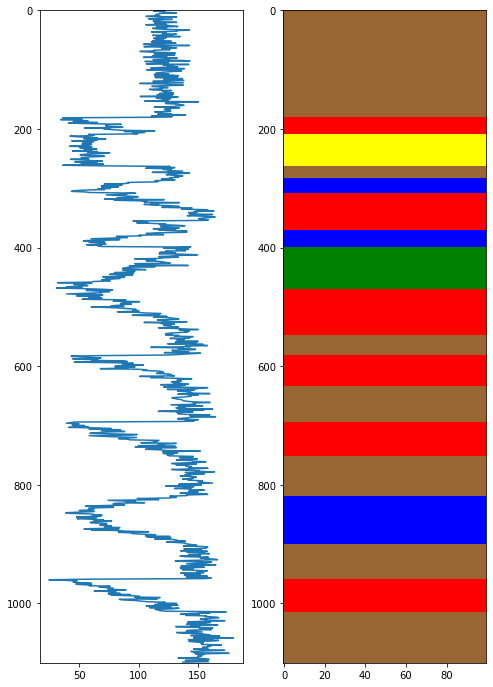

In [19]:
test_well = training_data[training_data['well_id'] == 1]
plot_well(test_well)

1100


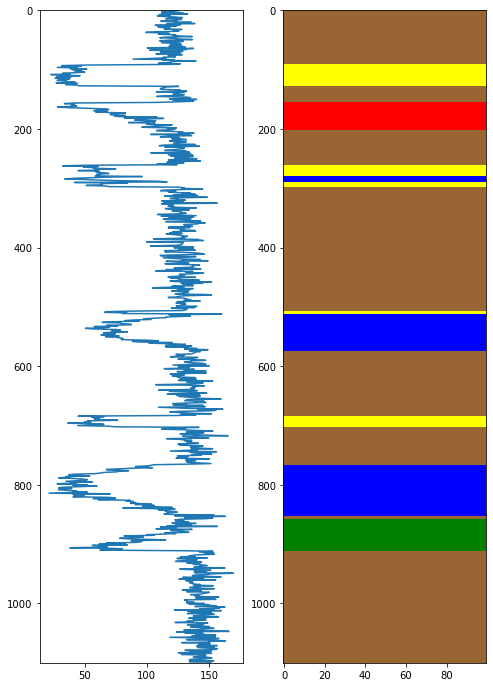

In [20]:
test_well = training_data[training_data['well_id'] == 2]
plot_well(test_well)

1100


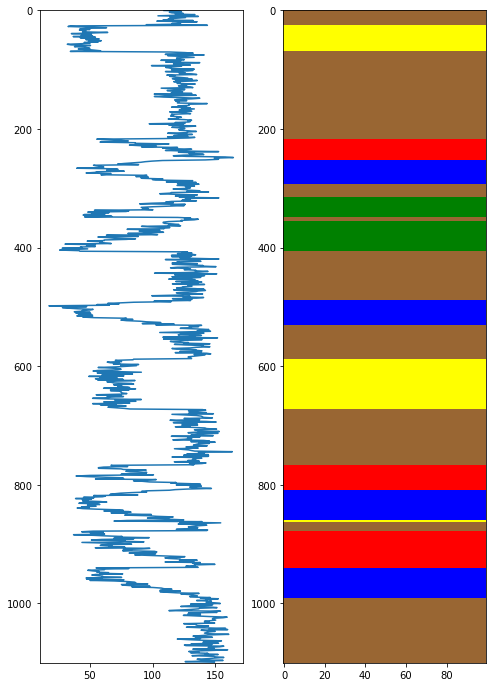

In [21]:
test_well = training_data[training_data['well_id'] == 3]
plot_well(test_well)

In [39]:
len(test_well.GR.values)

1100